In [2]:

import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import zero_mean, get_MOI, get_MOI2D, get_Pendulum_Invariance, get_SHM_Invariance, get_SHM2D_Invariance, get_Double_Pendulum_Invariance
from invariance_functions import degree_of_freedom, get_GPR_2Dmodel, get_SHM2D_data, evaluate_2Dmodel, get_double_pendulum_data
from local_invariance_kernels import get_SHM2D_Local_Invariance, get_Double_Pendulum_Local_Invariance
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [8]:
mean = zero_mean(4)

time_step = 0.1
training_time = 2
testing_time = 5

max_angle = 60
n_train = 3
train_starting_position1 = np.random.uniform(5, max_angle, (n_train))
train_starting_position2 = np.random.uniform(5, max_angle, (n_train))
train_starting_velocity1 = np.random.uniform(-max_angle/5, max_angle/5, (n_train))
train_starting_velocity2 = np.random.uniform(-max_angle/5, max_angle/5, (n_train))
test_starting_position1 = np.random.uniform(-max_angle, max_angle)
test_starting_position2 = np.random.uniform(-max_angle, max_angle)
test_starting_velocity1 = np.random.uniform(-max_angle/5, max_angle/5)
test_starting_velocity2 = np.random.uniform(-max_angle/5, max_angle/5)

print(train_starting_position1)
print(train_starting_position2)
print(train_starting_velocity1)
print(train_starting_velocity2)

print(test_starting_position1)
print(test_starting_position2)
print(test_starting_velocity1)
print(test_starting_velocity2)
data = get_double_pendulum_data(time_step, training_time, 1e-8, train_starting_position1, train_starting_position2, train_starting_velocity1, train_starting_velocity2) #switch
test_data = get_double_pendulum_data(time_step, testing_time, 1e-8,[test_starting_position1],[test_starting_position2],[test_starting_velocity1],[test_starting_velocity2] )
for jitter in [2e-5]:
#    print("current jitter %s" %jitter)
    moi = get_GPR_2Dmodel(get_MOI2D(), mean, data, 100)
    print("%s, "%round(moi.log_marginal_likelihood().numpy()))
    evaluate_moi = evaluate_2Dmodel(moi, test_data, time_step)
    print(evaluate_moi[:2])
    for invar_density in [8]: #np.arange(10, 30, 10):
            try:
#                kernel = get_Double_Pendulum_Local_Invariance(2, 20, jitter) #switch
                kernel = get_Double_Pendulum_Invariance(2, invar_density, jitter) #switch
                m = get_GPR_2Dmodel(kernel, mean, data, 100)
                print(round(m.log_marginal_likelihood().numpy()))
                evaluate_invariance = evaluate_2Dmodel(m, test_data, time_step)
                print(evaluate_invariance[:2])

            except tf.errors.InvalidArgumentError:
                print("jitter too small")
                break 

# %%


[22.15731328 49.22159408 19.89914385]
[16.69148833 58.27250806 45.94728149]
[-3.71884922 -4.45376257  1.50078363]
[ 8.74672897 11.50513111  0.74121696]
-48.55427655730115
-5.746760282481901
-8.553919625814036
11.39741183499931
959, 
(0.1907786650260113, 1.0425470051353452)
1007
(0.053269629580587397, 0.5183310071581608)


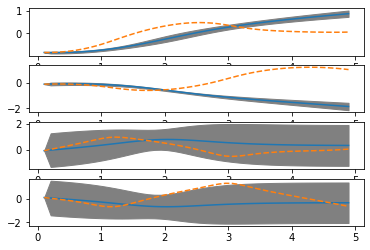

In [9]:
import matplotlib.pyplot as plt
t = np.linspace(0, testing_time, int(testing_time/time_step))[1:-1]
fig, axs = plt.subplots(4)
axs[0].plot(t,evaluate_moi[2][:,0])
axs[0].fill_between(t,evaluate_moi[2][:,0]+1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,0]-1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()), color="grey")
axs[0].plot(t, test_data[0][:,0],'--')
axs[1].plot(t,evaluate_moi[2][:,1])
axs[1].fill_between(t,evaluate_moi[2][:,1]+1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,1]-1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()), color="grey")
axs[1].plot(t, test_data[0][:,1],'--')
axs[2].plot(t,evaluate_moi[2][:,2])
axs[2].fill_between(t,evaluate_moi[2][:,2]+1.96*np.sqrt(evaluate_moi[3][:,2]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,2]-1.96*np.sqrt(evaluate_moi[3][:,2]+moi.likelihood.variance.numpy()), color="grey")
axs[2].plot(t, test_data[0][:,2],'--')
axs[3].plot(t,evaluate_moi[2][:,3])
axs[3].fill_between(t,evaluate_moi[2][:,3]+1.96*np.sqrt(evaluate_moi[3][:,3]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,3]-1.96*np.sqrt(evaluate_moi[3][:,3]+moi.likelihood.variance.numpy()), color="grey")
axs[3].plot(t, test_data[0][:,3],'--')

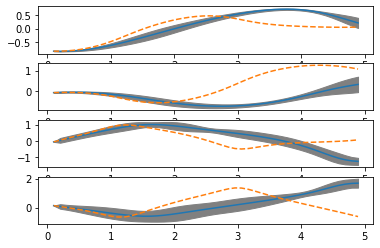

In [10]:
fig, axs = plt.subplots(4)
axs[0].plot(t,evaluate_invariance[2][:,0])
axs[0].fill_between(t,evaluate_invariance[2][:,0]+1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,0]-1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()), color="grey")
axs[0].plot(t, test_data[0][:,0],'--')
axs[1].plot(t,evaluate_invariance[2][:,1])
axs[1].fill_between(t,evaluate_invariance[2][:,1]+1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,1]-1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()), color="grey")
axs[1].plot(t, test_data[0][:,1],'--')
axs[2].plot(t,evaluate_invariance[2][:,2])
axs[2].fill_between(t,evaluate_invariance[2][:,2]+1.96*np.sqrt(evaluate_invariance[3][:,2]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,2]-1.96*np.sqrt(evaluate_invariance[3][:,2]+m.likelihood.variance.numpy()), color="grey")
axs[2].plot(t, test_data[0][:,2],'--')
axs[3].plot(t,evaluate_invariance[2][:,3])
axs[3].fill_between(t,evaluate_invariance[2][:,3]+1.96*np.sqrt(evaluate_invariance[3][:,3]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,3]-1.96*np.sqrt(evaluate_invariance[3][:,3]+m.likelihood.variance.numpy()), color="grey")
axs[3].plot(t, test_data[0][:,3],'--')